# Length dependency of conformational change

## Introduction

In this notebook, we set out to determine if there was a correlation between conformational change and the length of CDR loops or peptides.
We looked at both the correlation of bulk movements when loops where aligned on the framework regions and also the deformation effects when loops are aligned to one another.
All peptide conformations are measure from alignment on the antigen binding groove floor.

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns

## Loading Meta data

In [2]:
DATA_DIR = '../data/processed/apo-holo-tcr-pmhc-class-I-comparisons'

In [3]:
apo_holo_summary_df = pd.read_csv('../data/processed/apo-holo-tcr-pmhc-class-I/apo_holo_summary.csv')

apo_holo_summary_df['id'] = apo_holo_summary_df['file_name'].str.replace('.pdb$', '', regex=True)

In [4]:
cdr_types = ['CDR-A1', 'CDR-A2', 'CDR-A3','CDR-B1', 'CDR-B2', 'CDR-B3']
apo_holo_summary_df[cdr_types] = apo_holo_summary_df['cdr_sequences_collated'].str.split('-').apply(pd.Series)

In [5]:
apo_holo_summary_df

,file_name,pdb_id,structure_type,state,alpha_chain,beta_chain,antigen_chain,mhc_chain1,mhc_chain2,cdr_sequences_collated,peptide_sequence,mhc_slug,id,CDR-A1,CDR-A2,CDR-A3,CDR-B1,CDR-B2,CDR-B3
0,1ao7_D-E-C-A-B_tcr_pmhc.pdb,1ao7,tcr_pmhc,holo,D,E,C,A,B,DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLA...,LLFGYPVYV,hla_a_02_01,1ao7_D-E-C-A-B_tcr_pmhc,DRGSQS,IYSNGD,AVTTDSWGKLQ,MNHEY,SVGAGI,ASRPGLAGGRPEQY
1,1b0g_C-A-B_pmhc.pdb,1b0g,pmhc,apo,NaN,NaN,C,A,B,NaN,ALWGFFPVL,hla_a_02_01,1b0g_C-A-B_pmhc,NaN,NaN,NaN,NaN,NaN,NaN
2,1b0g_F-D-E_pmhc.pdb,1b0g,pmhc,apo,NaN,NaN,F,D,E,NaN,ALWGFFPVL,hla_a_02_01,1b0g_F-D-E_pmhc,NaN,NaN,NaN,NaN,NaN,NaN
3,1bd2_D-E-C-A-B_tcr_pmhc.pdb,1bd2,tcr_pmhc,holo,D,E,C,A,B,NSMFDY-ISSIKDK-AAMEGAQKLV-MNHEY-SVGAGI-ASSYPGG...,LLFGYPVYV,hla_a_02_01,1bd2_D-E-C-A-B_tcr_pmhc,NSMFDY,ISSIKDK,AAMEGAQKLV,MNHEY,SVGAGI,ASSYPGGGFYEQY
4,1bii_P-A-B_pmhc.pdb,1bii,pmhc,apo,NaN,NaN,P,A,B,NaN,RGPGRAFVTI,h2_dd,1bii_P-A-B_pmhc,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,7rtd_C-A-B_pmhc.pdb,7rtd,pmhc,apo,NaN,NaN,C,A,B,NaN,YLQPRTFLL,hla_a_02_01,7rtd_C-A-B_pmhc,NaN,NaN,NaN,NaN,NaN,NaN
387,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,D,E,C,A,B,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01,7rtr_D-E-C-A-B_tcr_pmhc,DRGSQS,IYSNGD,AVNRDDKII,SEHNR,FQNEAQ,ASSPDIEQY
388,8gvb_A-B-P-H-L_tcr_pmhc.pdb,8gvb,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RYPLTFGW,hla_a_24_02,8gvb_A-B-P-H-L_tcr_pmhc,YGATPY,YFSGDTLV,AVGFTGGGNKLT,SEHNR,FQNEAQ,ASSDRDRVPETQY
389,8gvg_A-B-P-H-L_tcr_pmhc.pdb,8gvg,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RFPLTFGW,hla_a_24_02,8gvg_A-B-P-H-L_tcr_pmhc,YGATPY,YFSGDTLV,AVGFTGGGNKLT,SEHNR,FQNEAQ,ASSDRDRVPETQY


## TCR Analysis

### Load Data

In [6]:
results_tcr_fw_align = pd.read_csv(os.path.join(DATA_DIR, 'rmsd_cdr_fw_align_results.csv'))
results_tcr_fw_align['alignment'] = 'framework'

In [7]:
results_tcr_loop_align = pd.read_csv(os.path.join(DATA_DIR, 'rmsd_cdr_loop_align_results.csv'))
results_tcr_loop_align['alignment'] = 'loop'

In [8]:
results_tcr = pd.concat([results_tcr_fw_align, results_tcr_loop_align])
results_tcr

,complex_id,structure_x_name,structure_y_name,chain_type,cdr,rmsd,alignment
0,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,1,1.932806,framework
1,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,2,1.308598,framework
2,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,3,1.244062,framework
3,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,beta_chain,1,0.809066,framework
4,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,beta_chain,2,0.688597,framework
...,...,...,...,...,...,...,...
809,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,alpha_chain,2,0.206414,loop
810,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,alpha_chain,3,0.459090,loop
811,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,1,0.255668,loop
812,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,2,0.175123,loop


### Merge with metadata

In [9]:
apo_holo_summary_cdrs_df = apo_holo_summary_df.melt(
    id_vars=[col for col in apo_holo_summary_df.columns if col not in cdr_types],
    var_name='cdr_type',
    value_name='cdr_sequence',
    value_vars=cdr_types,
)

In [10]:
apo_holo_summary_cdrs_df[['chain_type', 'cdr']] = apo_holo_summary_cdrs_df['cdr_type'].map(
    lambda cdr_type: ('alpha_chain' if cdr_type[-2] == 'A' else 'beta_chain', int(cdr_type[-1]))
).apply(pd.Series)

In [11]:
apo_holo_summary_cdrs_df['cdr_length'] = apo_holo_summary_cdrs_df['cdr_sequence'].str.len()

In [12]:
apo_holo_summary_cdrs_df

,file_name,pdb_id,structure_type,state,alpha_chain,beta_chain,antigen_chain,mhc_chain1,mhc_chain2,cdr_sequences_collated,peptide_sequence,mhc_slug,id,cdr_type,cdr_sequence,chain_type,cdr,cdr_length
0,1ao7_D-E-C-A-B_tcr_pmhc.pdb,1ao7,tcr_pmhc,holo,D,E,C,A,B,DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLA...,LLFGYPVYV,hla_a_02_01,1ao7_D-E-C-A-B_tcr_pmhc,CDR-A1,DRGSQS,alpha_chain,1,6.0
1,1b0g_C-A-B_pmhc.pdb,1b0g,pmhc,apo,NaN,NaN,C,A,B,NaN,ALWGFFPVL,hla_a_02_01,1b0g_C-A-B_pmhc,CDR-A1,NaN,alpha_chain,1,NaN
2,1b0g_F-D-E_pmhc.pdb,1b0g,pmhc,apo,NaN,NaN,F,D,E,NaN,ALWGFFPVL,hla_a_02_01,1b0g_F-D-E_pmhc,CDR-A1,NaN,alpha_chain,1,NaN
3,1bd2_D-E-C-A-B_tcr_pmhc.pdb,1bd2,tcr_pmhc,holo,D,E,C,A,B,NSMFDY-ISSIKDK-AAMEGAQKLV-MNHEY-SVGAGI-ASSYPGG...,LLFGYPVYV,hla_a_02_01,1bd2_D-E-C-A-B_tcr_pmhc,CDR-A1,NSMFDY,alpha_chain,1,6.0
4,1bii_P-A-B_pmhc.pdb,1bii,pmhc,apo,NaN,NaN,P,A,B,NaN,RGPGRAFVTI,h2_dd,1bii_P-A-B_pmhc,CDR-A1,NaN,alpha_chain,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2341,7rtd_C-A-B_pmhc.pdb,7rtd,pmhc,apo,NaN,NaN,C,A,B,NaN,YLQPRTFLL,hla_a_02_01,7rtd_C-A-B_pmhc,CDR-B3,NaN,beta_chain,3,NaN
2342,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,D,E,C,A,B,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01,7rtr_D-E-C-A-B_tcr_pmhc,CDR-B3,ASSPDIEQY,beta_chain,3,9.0
2343,8gvb_A-B-P-H-L_tcr_pmhc.pdb,8gvb,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RYPLTFGW,hla_a_24_02,8gvb_A-B-P-H-L_tcr_pmhc,CDR-B3,ASSDRDRVPETQY,beta_chain,3,13.0
2344,8gvg_A-B-P-H-L_tcr_pmhc.pdb,8gvg,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RFPLTFGW,hla_a_24_02,8gvg_A-B-P-H-L_tcr_pmhc,CDR-B3,ASSDRDRVPETQY,beta_chain,3,13.0


In [13]:
results_tcr = results_tcr.merge(
    apo_holo_summary_cdrs_df[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_x_name',
    right_on='file_name',
).merge(
    apo_holo_summary_cdrs_df[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_y_name',
    right_on='file_name',
).merge(
    apo_holo_summary_cdrs_df[['id',
                              'cdr_sequences_collated',
                              'peptide_sequence',
                              'mhc_slug',
                              'cdr_sequence',
                              'cdr_length',
                              'cdr_type',
                              'chain_type',
                              'cdr']],
    how='left',
    left_on=['complex_id', 'chain_type', 'cdr'],
    right_on=['id', 'chain_type', 'cdr'],
)

### Normalise data

In [14]:
results_tcr['comparison'] = results_tcr['state_x'] + '-' + results_tcr['state_y']
results_tcr['comparison'] = results_tcr['comparison'].map(lambda entry: 'apo-holo' if entry == 'holo-apo' else entry)
results_tcr = results_tcr.query("comparison == 'apo-holo'").reset_index(drop=True)

In [15]:
results_tcr['structure_comparison'] = results_tcr.apply(
    lambda row: '-'.join(sorted([row.structure_x_name, row.structure_y_name])),
    axis='columns',
)
results_tcr = results_tcr.drop_duplicates(['structure_comparison', 'chain_type', 'cdr', 'alignment'])

In [16]:
results_tcr = results_tcr.groupby(['cdr_sequences_collated',
                                   'alignment',
                                   'comparison',
                                   'cdr_length',
                                   'cdr_sequence',
                                   'cdr_type',
                                   'chain_type',
                                   'cdr'])['rmsd'].mean().reset_index()

### Visualise Results

#### Alignment on Framework region

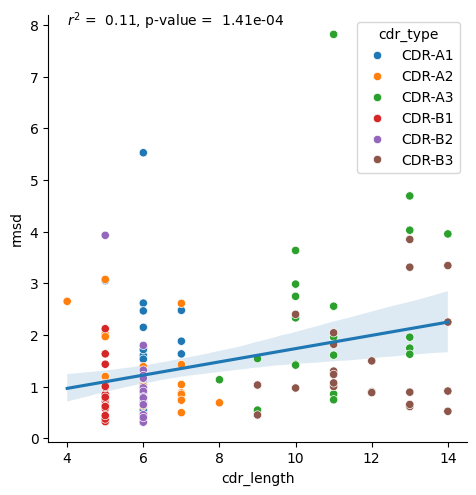

In [17]:
data = results_tcr.query("alignment == 'framework'")

r, p_val = scipy.stats.pearsonr(data['cdr_length'], data['rmsd'])

sns.lmplot(data.sort_values('cdr_type'), x='cdr_length', y='rmsd', scatter=False)
sns.scatterplot(data.sort_values('cdr_type'), x='cdr_length', y='rmsd', hue='cdr_type')

plt.text(4, 8, f'$r^2$ = {r**2: .2f}, p-value = {p_val: .2e}')

plt.show()

#### Alignment on loops

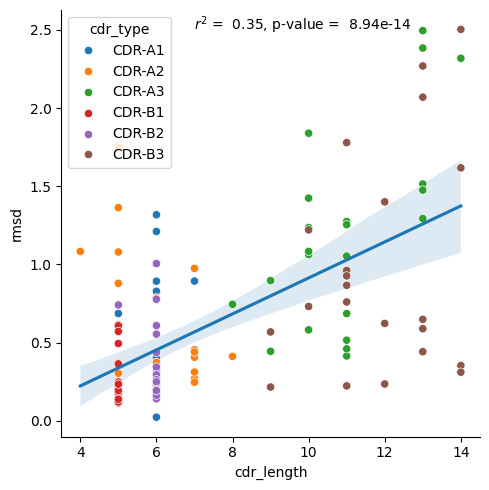

In [18]:
data = results_tcr.query("alignment == 'loop'")

r, p_val = scipy.stats.pearsonr(data['cdr_length'], data['rmsd'])

sns.lmplot(data.sort_values('cdr_type'), x='cdr_length', y='rmsd', scatter=False)
sns.scatterplot(data.sort_values('cdr_type'), x='cdr_length', y='rmsd', hue='cdr_type')

plt.text(7, 2.5, f'$r^2$ = {r**2: .2f}, p-value = {p_val: .2e}')

plt.show()

#### TCR apex calculations

In [19]:
results_per_res_tcr = pd.read_csv(os.path.join(DATA_DIR, 'tcr_per_res_apo_holo_loop_align.csv'))
results_per_res_tcr

,complex_id,structure_x_name,structure_y_name,chain_type,cdr,residue_name,residue_seq_id,residue_insert_code,rmsd,ca_distance,chi_angle_change,com_distance
0,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,1,ASP,27,NaN,4.922807,2.215234,-1.001709,3.836500
1,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,1,ARG,28,NaN,7.683418,2.322292,-1.010462,6.119157
2,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,1,GLY,29,NaN,0.657793,0.718576,NaN,0.452200
3,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,1,SER,36,NaN,1.224430,0.404912,-2.505061,0.866544
4,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,1,GLN,37,NaN,1.133408,0.467132,0.667185,0.798590
...,...,...,...,...,...,...,...,...,...,...,...,...
6228,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,3,ASP,109,NaN,0.507077,0.180564,0.198956,0.208659
6229,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,3,ILE,114,NaN,2.164965,0.158682,3.679442,0.829175
6230,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,3,GLU,115,NaN,1.577728,0.195887,3.091039,0.995351
6231,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,3,GLN,116,NaN,0.204783,0.197683,-0.014126,0.166472


In [20]:
results_per_res_tcr = results_per_res_tcr.merge(
    apo_holo_summary_cdrs_df[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_x_name',
    right_on='file_name',
).merge(
    apo_holo_summary_cdrs_df[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_y_name',
    right_on='file_name',
).merge(
    apo_holo_summary_cdrs_df[['id',
                              'cdr_sequences_collated',
                              'peptide_sequence',
                              'mhc_slug',
                              'cdr_sequence',
                              'cdr_length',
                              'cdr_type',
                              'chain_type',
                              'cdr']],
    how='left',
    left_on=['complex_id', 'chain_type', 'cdr'],
    right_on=['id', 'chain_type', 'cdr'],
)

In [21]:
results_per_res_tcr['comparison'] = results_per_res_tcr['state_x'] + '-' + results_per_res_tcr['state_y']
results_per_res_tcr['comparison'] = results_per_res_tcr['comparison'].map(
    lambda entry: 'apo-holo' if entry == 'holo-apo' else entry
)
results_per_res_tcr = results_per_res_tcr.query("comparison == 'apo-holo'").reset_index(drop=True)

In [22]:
results_per_res_tcr['structure_comparison'] = results_per_res_tcr.apply(
    lambda row: '-'.join(sorted([row.structure_x_name, row.structure_y_name])),
    axis='columns',
)
results_per_res_tcr = results_per_res_tcr.drop_duplicates(['structure_comparison', 'chain_type', 'cdr',
                                                           'residue_name', 'residue_seq_id', 'residue_insert_code'])

In [23]:
results_per_res_tcr

,complex_id,structure_x_name,structure_y_name,chain_type,cdr,residue_name,residue_seq_id,residue_insert_code,rmsd,ca_distance,...,state_y,id,cdr_sequences_collated,peptide_sequence,mhc_slug,cdr_sequence,cdr_length,cdr_type,comparison,structure_comparison
0,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,1,ASP,27,NaN,4.922807,2.215234,...,apo,3qdg_D-E-C-A-B_tcr_pmhc,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01,DRGSQS,6.0,CDR-A1,apo-holo,3qdg_D-E-C-A-B_tcr_pmhc.pdb-3qeu_A-B_tcr.pdb
36,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,1,ARG,28,NaN,7.683418,2.322292,...,apo,3qdg_D-E-C-A-B_tcr_pmhc,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01,DRGSQS,6.0,CDR-A1,apo-holo,3qdg_D-E-C-A-B_tcr_pmhc.pdb-3qeu_A-B_tcr.pdb
72,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,1,GLY,29,NaN,0.657793,0.718576,...,apo,3qdg_D-E-C-A-B_tcr_pmhc,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01,DRGSQS,6.0,CDR-A1,apo-holo,3qdg_D-E-C-A-B_tcr_pmhc.pdb-3qeu_A-B_tcr.pdb
108,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,1,SER,36,NaN,1.224430,0.404912,...,apo,3qdg_D-E-C-A-B_tcr_pmhc,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01,DRGSQS,6.0,CDR-A1,apo-holo,3qdg_D-E-C-A-B_tcr_pmhc.pdb-3qeu_A-B_tcr.pdb
144,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,1,GLN,37,NaN,1.133408,0.467132,...,apo,3qdg_D-E-C-A-B_tcr_pmhc,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01,DRGSQS,6.0,CDR-A1,apo-holo,3qdg_D-E-C-A-B_tcr_pmhc.pdb-3qeu_A-B_tcr.pdb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158220,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,3,ASP,109,NaN,0.507077,0.180564,...,holo,7rtr_D-E-C-A-B_tcr_pmhc,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01,ASSPDIEQY,9.0,CDR-B3,apo-holo,7n1d_A-B_tcr.pdb-7rtr_D-E-C-A-B_tcr_pmhc.pdb
158256,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,3,ILE,114,NaN,2.164965,0.158682,...,holo,7rtr_D-E-C-A-B_tcr_pmhc,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01,ASSPDIEQY,9.0,CDR-B3,apo-holo,7n1d_A-B_tcr.pdb-7rtr_D-E-C-A-B_tcr_pmhc.pdb
158292,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,3,GLU,115,NaN,1.577728,0.195887,...,holo,7rtr_D-E-C-A-B_tcr_pmhc,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01,ASSPDIEQY,9.0,CDR-B3,apo-holo,7n1d_A-B_tcr.pdb-7rtr_D-E-C-A-B_tcr_pmhc.pdb
158328,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,3,GLN,116,NaN,0.204783,0.197683,...,holo,7rtr_D-E-C-A-B_tcr_pmhc,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01,ASSPDIEQY,9.0,CDR-B3,apo-holo,7n1d_A-B_tcr.pdb-7rtr_D-E-C-A-B_tcr_pmhc.pdb


In [24]:
def compute_apex_movement(loop: pd.DataFrame) -> float:
    loop_len = len(loop)

    if loop_len % 2 == 0:
        return np.mean([loop.iloc[loop_len // 2]['ca_distance'], loop.iloc[(loop_len // 2) - 1]['ca_distance']])

    return loop.iloc[loop_len // 2]['ca_distance']

In [25]:
results_tcr_apex = results_per_res_tcr.groupby(['structure_x_name',
                                                'structure_y_name',
                                                'cdr_type',
                                                'cdr',
                                                'chain_type',
                                                'cdr_length']).apply(compute_apex_movement)
results_tcr_apex.name = 'apex_ca_distance'
results_tcr_apex = results_tcr_apex.reset_index()

In [26]:
results_tcr_apex

,structure_x_name,structure_y_name,cdr_type,cdr,chain_type,cdr_length,apex_ca_distance
0,1ao7_D-E-C-A-B_tcr_pmhc.pdb,3qh3_A-B_tcr.pdb,CDR-A1,1,alpha_chain,6.0,0.153049
1,1ao7_D-E-C-A-B_tcr_pmhc.pdb,3qh3_A-B_tcr.pdb,CDR-A2,2,alpha_chain,6.0,0.447122
2,1ao7_D-E-C-A-B_tcr_pmhc.pdb,3qh3_A-B_tcr.pdb,CDR-A3,3,alpha_chain,11.0,2.461146
3,1ao7_D-E-C-A-B_tcr_pmhc.pdb,3qh3_A-B_tcr.pdb,CDR-B1,1,beta_chain,5.0,0.319232
4,1ao7_D-E-C-A-B_tcr_pmhc.pdb,3qh3_A-B_tcr.pdb,CDR-B2,2,beta_chain,6.0,0.167444
...,...,...,...,...,...,...,...
569,7r7z_A-B_tcr.pdb,7r80_A-B-E-C-D_tcr_pmhc.pdb,CDR-A2,2,alpha_chain,7.0,0.173771
570,7r7z_A-B_tcr.pdb,7r80_A-B-E-C-D_tcr_pmhc.pdb,CDR-A3,3,alpha_chain,11.0,0.508615
571,7r7z_A-B_tcr.pdb,7r80_A-B-E-C-D_tcr_pmhc.pdb,CDR-B1,1,beta_chain,5.0,0.108211
572,7r7z_A-B_tcr.pdb,7r80_A-B-E-C-D_tcr_pmhc.pdb,CDR-B2,2,beta_chain,6.0,0.219891


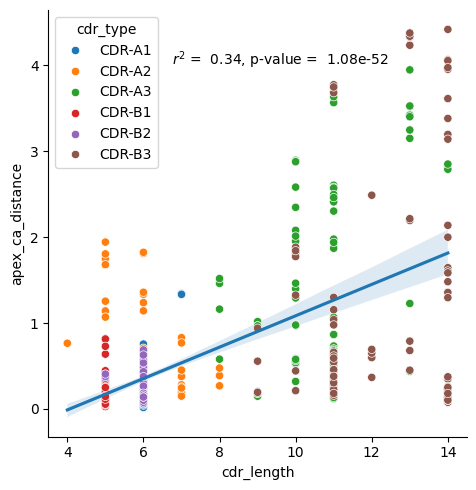

In [27]:
r, p_val = scipy.stats.pearsonr(results_tcr_apex['cdr_length'], results_tcr_apex['apex_ca_distance'])

sns.lmplot(results_tcr_apex.sort_values('cdr_type'), x='cdr_length', y='apex_ca_distance', scatter=False)
sns.scatterplot(results_tcr_apex.sort_values('cdr_type'), x='cdr_length', y='apex_ca_distance', hue='cdr_type')

plt.text(6.75, 4, f'$r^2$ = {r**2: .2f}, p-value = {p_val: .2e}')

plt.show()

## Peptide Analysis

### Load data

In [28]:
results_peptide = pd.read_csv(os.path.join(DATA_DIR, 'pmhc_tcr_contact_apo_holo.csv'))

results_peptide = results_peptide.query("chain_type == 'antigen_chain'")
results_peptide = results_peptide.drop(columns=['chain_type', 'tcr_contact'])

results_peptide

,complex_id,structure_x_name,structure_y_name,rmsd
2,5c0a_D-E-C-A-B_tcr_pmhc,5c0a_D-E-C-A-B_tcr_pmhc.pdb,5n1y_C-A-B_pmhc.pdb,0.448858
5,5wlg_D-E-C-A-B_tcr_pmhc,5wlg_D-E-C-A-B_tcr_pmhc.pdb,5wli_C-A-B_pmhc.pdb,0.498148
8,5wlg_D-E-C-A-B_tcr_pmhc,5wlg_D-E-C-A-B_tcr_pmhc.pdb,5wli_F-D-E_pmhc.pdb,0.519507
11,5wlg_D-E-C-A-B_tcr_pmhc,5wlg_D-E-C-A-B_tcr_pmhc.pdb,5wli_I-G-H_pmhc.pdb,0.459025
14,5wlg_D-E-C-A-B_tcr_pmhc,5wlg_D-E-C-A-B_tcr_pmhc.pdb,5wli_L-J-K_pmhc.pdb,0.494705
...,...,...,...,...
3301,7rtr_D-E-C-A-B_tcr_pmhc,7n6d_O-M-N_pmhc.pdb,7rtd_C-A-B_pmhc.pdb,0.486296
3304,7rtr_D-E-C-A-B_tcr_pmhc,7n6d_O-M-N_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,0.448905
3307,7rtr_D-E-C-A-B_tcr_pmhc,7p3d_C-A-B_pmhc.pdb,7rtd_C-A-B_pmhc.pdb,0.773692
3310,7rtr_D-E-C-A-B_tcr_pmhc,7p3d_C-A-B_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,0.765295


### Merge with metadata

In [29]:
apo_holo_summary_df['peptide_length'] = apo_holo_summary_df['peptide_sequence'].str.len()

In [30]:
results_peptide = results_peptide.merge(
    apo_holo_summary_df[['file_name', 'pdb_id', 'state']],
    how='left',
    left_on='structure_x_name',
    right_on='file_name',
).merge(
    apo_holo_summary_df[['file_name', 'pdb_id', 'state']],
    how='left',
    left_on='structure_y_name',
    right_on='file_name',
).merge(
    apo_holo_summary_df[['id', 'peptide_sequence', 'peptide_length', 'mhc_slug']],
    how='left',
    left_on='complex_id',
    right_on='id',
)

### Normalise data

In [31]:
results_peptide['comparison'] = results_peptide['state_x'] + '-' + results_peptide['state_y']
results_peptide['comparison'] = results_peptide['comparison'].map(
    lambda entry: 'apo-holo' if entry == 'holo-apo' else entry,
)
results_peptide = results_peptide.query("comparison == 'apo-holo'").reset_index(drop=True)

In [32]:
results_peptide['structure_comparison'] = results_peptide.apply(
    lambda row: '-'.join(sorted([row.structure_x_name, row.structure_y_name])),
    axis='columns',
)
results_peptide = results_peptide.drop_duplicates('structure_comparison')

In [33]:
results_peptide = results_peptide.groupby(['peptide_sequence',
                                           'comparison',
                                           'peptide_length',
                                           'mhc_slug'])['rmsd'].mean().reset_index()

In [34]:
results_peptide

,peptide_sequence,comparison,peptide_length,mhc_slug,rmsd
0,AAGIGILTV,apo-holo,9.0,hla_a_02_01,1.025622
1,ALGIGILTV,apo-holo,9.0,hla_a_02_01,1.274516
2,ALWGFFPVL,apo-holo,9.0,hla_a_02_01,0.351748
3,ALWGPDPAAA,apo-holo,10.0,hla_a_02_01,0.703094
4,APRGPHGGAASGL,apo-holo,13.0,hla_b_07_02,3.523593
...,...,...,...,...,...
75,VVVGAGGVGK,apo-holo,10.0,hla_a_11_01,1.483028
76,YGFRNVVHI,apo-holo,9.0,h2_db,0.275006
77,YLGGPDFPTI,apo-holo,10.0,hla_a_02_01,0.868938
78,YLQPRTFLL,apo-holo,9.0,hla_a_02_01,0.584577


### Visualise results

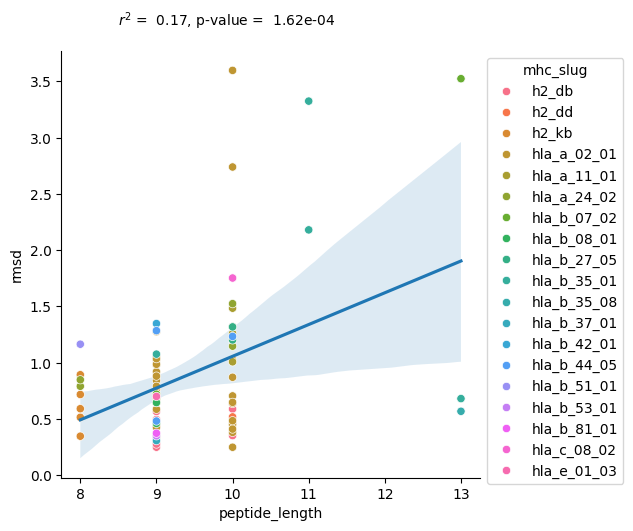

In [35]:
r, p_val = scipy.stats.pearsonr(results_peptide['peptide_length'], results_peptide['rmsd'])

sns.lmplot(results_peptide.sort_values('mhc_slug'), x='peptide_length', y='rmsd', scatter=False)
ax = sns.scatterplot(results_peptide.sort_values('mhc_slug'), x='peptide_length', y='rmsd', hue='mhc_slug')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.text(8.5, 4, f'$r^2$ = {r**2: .2f}, p-value = {p_val: .2e}')

plt.show()

## Conclusion

Both TCR CDR loops and peptides show a correlation between length and amount of conformational change.
For the TCRs, there is a correlation in both paradigms, framework alignment and loop alignment, but the correlation is much stronger looking at the loop alignments.
The increased correlation for loop alignments make sense since the conformational changes from the framework regions can be driven by other parts of the protein, but when the loops are aligned together, the only differences can be driven by changes in the loops themselves, implying the loop length has more of an effect.